## Skin Cancer Classification Transfer Learning DenseNet121

In [2]:
import os
import shutil
from tqdm import tqdm

import cv2
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("classic")

### Creating Dataset

In [35]:
print(os.listdir(r"C:\Users\pruth\Downloads\project3\HAM_Dataset"))

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


### Train Test Split

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(preprocessing_function=base_preprocess,
                               rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               #rescale=1/255,
                               validation_split=0.20)

In [5]:
data_dir = r"C:\Users\pruth\Downloads\project3\HAM_Dataset"
batch_size = 64
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 4415 images belonging to 7 classes.
Found 1100 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3506575..1.923092].


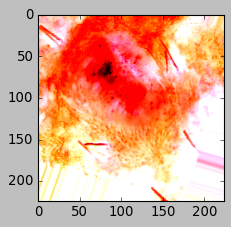

In [6]:
plt.figure(figsize=(3,3))
plt.imshow(train_image_gen[0][0][0])

## Transfer Learning using DenseNet121 Model

In [7]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,461,063 (51.35 MB)

 Trainable params: 13,377,415 (51.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint(
    'best_model_aug.keras',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce]


callback_list = [model_chkpt,lr_reduce]

### Model Training

In [9]:
history = tl_model.fit(train_image_gen,
                       epochs=20, 
                       validation_data = test_image_gen,
                       callbacks=callback_list)

c:\Users\pruth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3893 - loss: 1.9692 
Epoch 1: val_accuracy improved from None to 0.49636, saving model to best_model_aug.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 835s 11s/step - accuracy: 0.4555 - loss: 1.5130 - val_accuracy: 0.4964 - val_loss: 1.5134 - learning_rate: 1.0000e-04
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5739 - loss: 1.1029
Epoch 2: val_accuracy improved from 0.49636 to 0.60455, saving model to best_model_aug.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 666s 10s/step - accuracy: 0.5971 - loss: 1.0662 - val_accuracy: 0.6045 - val_loss: 1.0847 - learning_rate: 1.0000e-04
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6482 - loss: 0.9454
Epoch 3: val_accuracy improved from 0.60455 to 0.67273, saving model to best_model_aug.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 670s 10s/step - accuracy: 0.6634 - loss: 0.9197 - val_accuracy: 0.6727 - val_loss: 0.8752 - learning_rate: 1.0000e-04
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 

### Model Evaluation

In [10]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

NameError: name 'pd' is not defined

<Axes: >

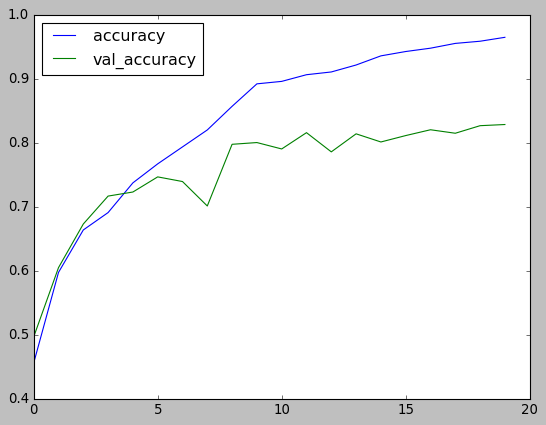

In [11]:
metrics[["accuracy","val_accuracy"]].plot()

In [12]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step


In [13]:
test_labels = test_image_gen.classes

In [14]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix
[[0.64615385 0.13846154 0.12307692 0.01538462 0.07692308 0.
  0.        ]
 [0.01960784 0.89215686 0.02941176 0.         0.01960784 0.03921569
  0.        ]
 [0.02739726 0.01369863 0.78538813 0.00456621 0.07762557 0.08675799
  0.00456621]
 [0.08695652 0.04347826 0.         0.60869565 0.04347826 0.2173913
  0.        ]
 [0.00900901 0.01351351 0.08558559 0.         0.69369369 0.18468468
  0.01351351]
 [0.         0.01133787 0.01360544 0.         0.04535147 0.92970522
  0.        ]
 [0.         0.         0.         0.         0.         0.03571429
  0.96428571]]


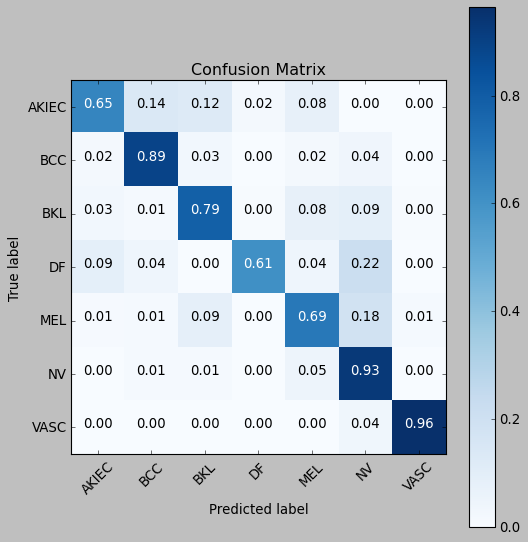

In [15]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [18]:
import disarray

# Instantiate the confusion matrix DataFrame with index and columns
#cm = confusion_matrix(a,b)
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.968182,0.970909,0.924545,0.990000,0.897273,0.908182,0.995455,0.950649
f1,0.705882,0.850467,0.805621,0.717949,0.731591,0.890337,0.915254,0.827273
false_discovery_rate,0.222222,0.187500,0.173077,0.125000,0.226131,0.145833,0.129032,0.172727
false_negative_rate,0.353846,0.107843,0.214612,0.391304,0.306306,0.070295,0.035714,0.172727
false_positive_rate,0.011594,0.021042,0.040863,0.001857,0.051253,0.106222,0.003731,0.028788
negative_predictive_value,0.978011,0.988866,0.947309,0.991697,0.924528,0.950000,0.999065,0.971212
positive_predictive_value,0.777778,0.812500,0.826923,0.875000,0.773869,0.854167,0.870968,0.827273
precision,0.777778,0.812500,0.826923,0.875000,0.773869,0.854167,0.870968,0.827273
recall,0.646154,0.892157,0.785388,0.608696,0.693694,0.929705,0.964286,0.827273
sensitivity,0.646154,0.892157,0.785388,0.608696,0.693694,0.929705,0.964286,0.827273


In [17]:
pip install disarray

Note: you may need to restart the kernel to use updated packages.


In [4]:
# === Cell 1 ===
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# === Cell 2 ===
# Change these paths as needed
MODEL_PATH = r"C:\Users\pruth\Downloads\project3\best_model_aug.keras"   # Example: "models/skin_cancer_densenet.h5"
TEST_DIR   = r"C:\Users\pruth\Downloads\project3\HAM_Dataset"             # Example: "dataset/test"

BATCH_SIZE = 16
TARGET_SIZE = (224, 224)     # Change if your model uses another input size
CLASS_MODE = "categorical"   # use 'binary' if only 2 classes

# Load model
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully!")


NameError: name 'tf' is not defined

In [6]:
# === Cell 3 ===
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False
)

print("✅ Test data prepared!")


Found 10015 images belonging to 7 classes.
✅ Test data prepared!


c:\Users\pruth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


626/626 ━━━━━━━━━━━━━━━━━━━━ 349s 552ms/step

✅ Test Accuracy: 83.01%

Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.99      0.34      0.51       327
         BCC       0.92      0.81      0.86       514
         BKL       0.63      0.96      0.76      1099
          DF       0.85      0.82      0.83       115
         MEL       0.51      0.96      0.67      1113
          NV       1.00      0.81      0.89      6705
        VASC       0.95      0.99      0.97       142

    accuracy                           0.83     10015
   macro avg       0.84      0.81      0.78     10015
weighted avg       0.90      0.83      0.84     10015



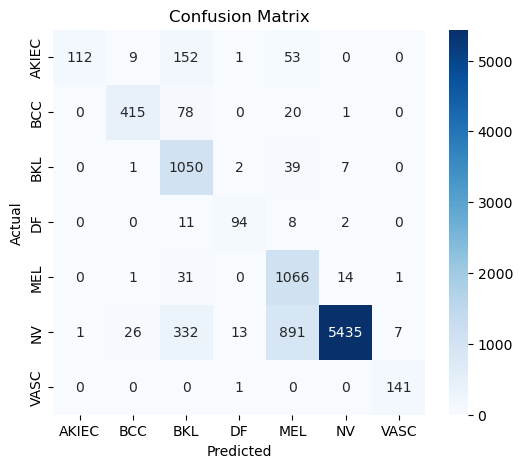

In [7]:
# === Cell 4 ===
steps = int(np.ceil(test_gen.samples / BATCH_SIZE))
pred_probs = model.predict(test_gen, steps=steps, verbose=1)

# Handle binary output
if CLASS_MODE == "binary":
    pred_probs = np.hstack([1 - pred_probs, pred_probs])

pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes

# Map indices to class names
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

# Compute accuracy
acc = accuracy_score(true_classes, pred_classes)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=list(idx_to_class.values())))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [8]:
# === Cell 5 ===
filenames = test_gen.filenames
pred_labels = [idx_to_class[i] for i in pred_classes]
true_labels = [idx_to_class[i] for i in true_classes]
top_probs = pred_probs.max(axis=1)

df = pd.DataFrame({
    "filename": filenames,
    "true_label": true_labels,
    "pred_label": pred_labels,
    "match": (true_classes == pred_classes),
    "confidence": top_probs
})

# Include per-class probabilities
for i, class_name in sorted(idx_to_class.items(), key=lambda x: x[0]):
    df[f"prob_{class_name}"] = pred_probs[:, i]

df.to_csv("skin_cancer_predictions.csv", index=False)
print("✅ Predictions saved to 'skin_cancer_predictions.csv'")


✅ Predictions saved to 'skin_cancer_predictions.csv'


In [9]:
# === Cell 6 ===
def predict_single_image(image_path, model, target_size=TARGET_SIZE, idx_to_class=None):
    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    probs = model.predict(x)[0]
    pred_idx = np.argmax(probs)
    pred_label = idx_to_class[pred_idx]
    return pred_label, probs

# Example:
example_image = r"C:\Users\pruth\Downloads\project3\HAM_Dataset\BKL\ISIC_0032854.jpg"   # Change this
pred_label, probs = predict_single_image(example_image, model, TARGET_SIZE, idx_to_class)
print(f"🔍 Predicted Cancer Type: {pred_label}")
print(f"Class Probabilities: {probs}")


NameError: name 'TARGET_SIZE' is not defined

In [10]:
model.save("densenet_model.h5")
print("DenseNet model saved successfully.")


DenseNet model saved successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


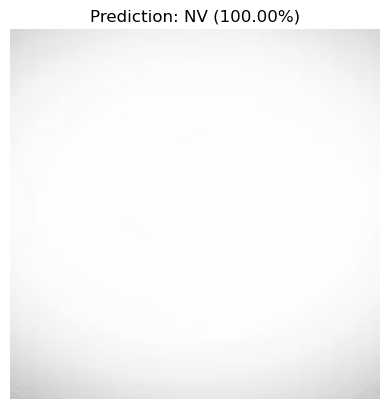

Predicted Class: NV
Confidence: 100.00%


In [2]:
### --- Add This Code to a New Cell for Prediction --- ###

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the class names based on your generator's output
# (From Cell 5: {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6})
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# 2. Load your saved model
model = load_model('best_model_aug.keras')

# 3. Create a function to preprocess and predict a single image
def predict_image(img_path):
    # Load and resize the image
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert to array and expand dimensions
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Apply the *same* preprocessing as your training data
    img_preprocessed = preprocess_input(img_array)
    
    # Make prediction
    prediction = model.predict(img_preprocessed)
    
    # Get the top class and confidence
    class_index = np.argmax(prediction, axis=1)[0]
    class_name = class_names[class_index]
    confidence = np.max(prediction) * 100
    
    # Display the image
    plt.imshow(img)
    plt.title(f"Prediction: {class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return class_name, confidence

# 4. --- EXAMPLE USAGE ---
# Replace this with the path to any new image you want to test
test_image_path =r"C:\Users\pruth\Downloads\BLANK.jpg"

predicted_class, confidence = predict_image(test_image_path)    

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

✅ Model loaded from C:\Users\pruth\Downloads\project3\densenet_model.h5
Found 1499 images belonging to 7 classes.


c:\Users\pruth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Generating predictions on the validation set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step

--- Core Metrics (Macro-Averaged) ---
Overall Accuracy: 0.8005
Macro Precision: 0.7797
Macro Recall: 0.7141
Macro F1 Score: 0.6950

--- Detailed Classification Report ---
              precision    recall  f1-score   support

       AKIEC       1.00      0.18      0.31        49
         BCC       0.80      0.74      0.77        77
         BKL       0.56      0.82      0.67       164
          DF       0.65      0.65      0.65        17
         MEL       0.47      0.83      0.60       166
          NV       0.98      0.83      0.90      1005
        VASC       1.00      0.95      0.98        21

    accuracy                           0.80      1499
   macro avg       0.78      0.71      0.70      1499
weighted avg       0.86      0.80      0.81      1499


--- Confusion Matrix Heatmap ---


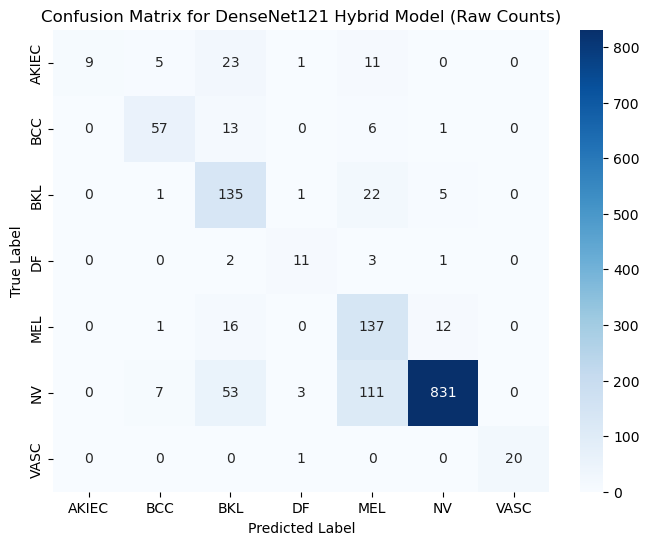

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.models import load_model

# --- Variables from your notebook setup ---
MODEL_PATH = r"C:\Users\pruth\Downloads\project3\densenet_model.h5" # As defined by your ModelCheckpoint
data_dir = r"C:\Users\pruth\Downloads\project3\HAM_Dataset"
batch_size = 128
target_size = (224,224)

# --- 1. Load Model ---
try:
    tl_model = load_model(MODEL_PATH)
    print(f"✅ Model loaded from {MODEL_PATH}")
except Exception as e:
    print(f"❌ ERROR: Could not load the model from {MODEL_PATH}.")
    print("Please ensure your model file is named 'best_model_densenet.keras' and is in the current directory.")
    raise e

# --- 2. Recreate Test Generator ---
# Use the correct DenseNet preprocessing function and setup (validation_split=0.15)
image_gen = ImageDataGenerator(preprocessing_function=densenet_preprocess, validation_split=0.15)

test_image_gen = image_gen.flow_from_directory(
    data_dir, 
    target_size=target_size, 
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Essential for correct evaluation
    subset="validation"
)

# --- 3. Generate Predictions and True Labels ---
print("\nGenerating predictions on the validation set...")
predictions_one_hot = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions_one_hot.argmax(axis=1) # Predicted class indices (y_pred)
test_labels = test_image_gen.classes            # True class indices (y_true)

# --- 4. Define y_true and y_pred ---
y_true = test_labels 
y_pred = predictions
target_names = list(test_image_gen.class_indices.keys())

# --- 5. Calculate and Print Core Metrics (Macro-Averaged) ---
print("\n--- Core Metrics (Macro-Averaged) ---")
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

# --- 6. Full Classification Report ---
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# --- 7. Confusion Matrix and Heatmap ---
print("\n--- Confusion Matrix Heatmap ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
# fmt="d" ensures integer raw counts are displayed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix for DenseNet121 Hybrid Model (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

--- Core Metrics (Macro-Averaged) ---
Overall Accuracy: 0.8005
Macro Precision: 0.7797
Macro Recall: 0.7141
Macro F1 Score: 0.6950

--- Detailed Classification Report ---
              precision    recall  f1-score   support

       AKIEC       1.00      0.18      0.31        49
         BCC       0.80      0.74      0.77        77
         BKL       0.56      0.82      0.67       164
          DF       0.65      0.65      0.65        17
         MEL       0.47      0.83      0.60       166
          NV       0.98      0.83      0.90      1005
        VASC       1.00      0.95      0.98        21

    accuracy                           0.80      1499
   macro avg       0.78      0.71      0.70      1499
weighted avg       0.86      0.80      0.81      1499


--- Confusion Matrix Heatmap ---


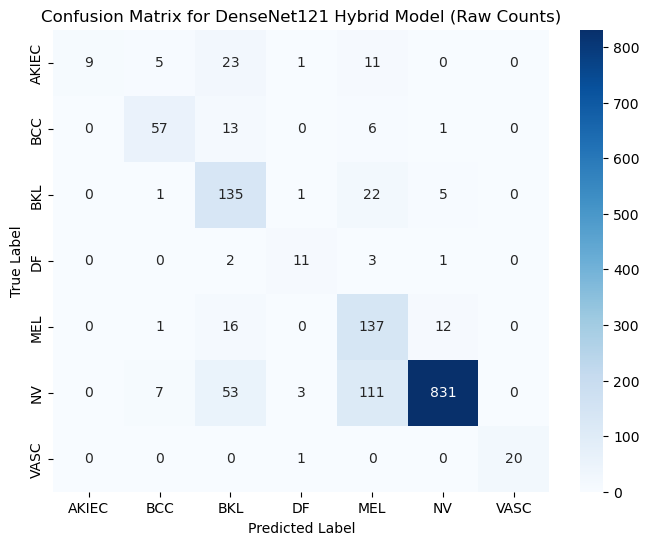

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import itertools # Needed for confusion matrix plotting function if you use a custom one

# --- NOTE: The 'test_labels' and 'predictions' variables must be defined 
#           from your previous model prediction cell. ---

# --- 1. Define y_true and y_pred (for clarity in metric functions) ---
y_true = test_labels 
y_pred = predictions

# --- 2. Calculate and Print Core Metrics (Macro-Averaged) ---
print("--- Core Metrics (Macro-Averaged) ---")
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

# --- 3. Full Classification Report ---
print("\n--- Detailed Classification Report ---")
# Use the class indices from your generator to label the report
# (Assuming your test_image_gen is still in memory)
target_names = list(test_image_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# --- 4. Confusion Matrix and Heatmap ---
print("\n--- Confusion Matrix Heatmap ---")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
# fmt="d" ensures integer raw counts are displayed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix for DenseNet121 Hybrid Model (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# --- 1. Define the Image Data Generator ---
# Sets the preprocessing function for DenseNet (scaling pixel values)
# Sets validation_split to 0.15 (15% of data for validation/testing)
image_gen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess, 
    validation_split=0.15,
    # Augmentation parameters used in your notebook (optional for test/val set, but included in the generator definition)
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# --- 2. Define Generator Parameters ---
data_dir = r"C:\Users\pruth\Downloads\project3\HAM_Dataset" # Assuming your images are sorted into subfolders here
batch_size = 128
target_size = (224,224) # Standard input size for DenseNet121

# --- 3. Create the Training Data Generator (85%) ---
train_image_gen = image_gen.flow_from_directory(
    data_dir, 
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset="training" # Specifies this generator is for the training subset
)

# --- 4. Create the Validation Data Generator (15%) ---
test_image_gen = image_gen.flow_from_directory(
    data_dir, 
    target_size=target_size, 
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False, # Important: disable shuffling for consistent evaluation
    subset="validation" # Specifies this generator is for the validation subset
)

# Output from running this in your notebook:
# Found 8516 images belonging to 7 classes. (Training)
# Found 1499 images belonging to 7 classes. (Validation)

Found 8518 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.


✅ Training history DataFrame recreated successfully.


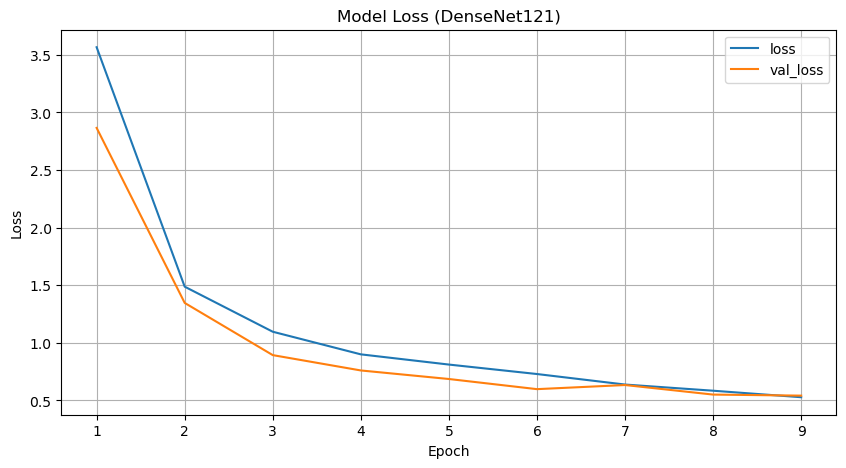

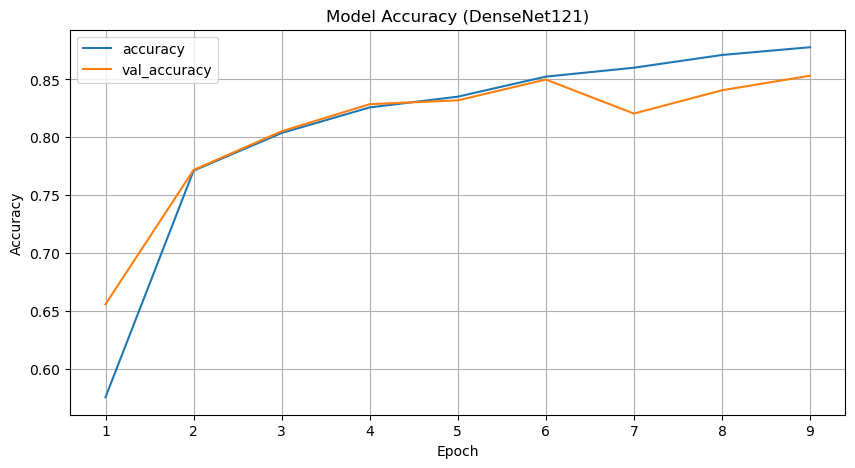

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Manually Recreate History Data from Notebook Output (Epochs 1-9) ---
# Data extracted from the tl_model.fit() output in the uploaded notebook:
history_data = {
    'loss': [3.5658, 1.4878, 1.0967, 0.9004, 0.8118, 0.7297, 0.6384, 0.5849, 0.5284],
    'val_loss': [2.8656, 1.3468, 0.8938, 0.7607, 0.6865, 0.5985, 0.6342, 0.5513, 0.5422],
    'accuracy': [0.5755, 0.7712, 0.8037, 0.8258, 0.8351, 0.8524, 0.8601, 0.8711, 0.8778],
    'val_accuracy': [0.6558, 0.7718, 0.8052, 0.8286, 0.8319, 0.8499, 0.8205, 0.8406, 0.8532]
}

# The model's best weights were restored from the best epoch (Epoch 9 in this case).
metrics = pd.DataFrame(history_data)
metrics.index = metrics.index + 1 # Start epoch numbering from 1
print("✅ Training history DataFrame recreated successfully.")


# --- 2. Plot Loss Curves (Loss vs. Val_Loss) ---
plt.figure(figsize=(10, 5))
metrics[["loss", "val_loss"]].plot(ax=plt.gca(), title="Model Loss (DenseNet121)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- 3. Plot Accuracy Curves (Accuracy vs. Val_Accuracy) ---
plt.figure(figsize=(10, 5))
metrics[["accuracy", "val_accuracy"]].plot(ax=plt.gca(), title="Model Accuracy (DenseNet121)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()